In [3]:
# データベース接続　他ファイルへ移動させる
import pymysql
from config import get_db_connection

connection = get_db_connection()

connection.commit()
cur = connection.cursor(dictionary=True)

# データベースから値取れているか、件数の確認
cur.execute('SELECT * FROM houses;')
test = cur.fetchall()
print("重複データ削除前のデータ個数：",len(test))

#重複行の削除　全項目が同じなら削除
cur.execute('DELETE FROM houses WHERE id NOT IN (SELECT min_id from (SELECT MIN(id) AS min_id FROM houses GROUP BY title, address, access, age, floor, fee, management_fee, deposit, gratuity, madori, menseki) AS tmp);')
connection.commit()

# 重複削除後データ件数確認
cur.execute('SELECT * FROM houses;')
test = cur.fetchall()
print("重複データ削除前のデータ個数：",len(test))

重複データ削除前のデータ個数： 958
重複データ削除前のデータ個数： 906


データの個数： 906
        rent
0      56000
1      56000
2      58000
3      59000
4      60000
..       ...
901  1720000
902  1900000
903  1900000
904  2500000
905  2500000

[906 rows x 1 columns]


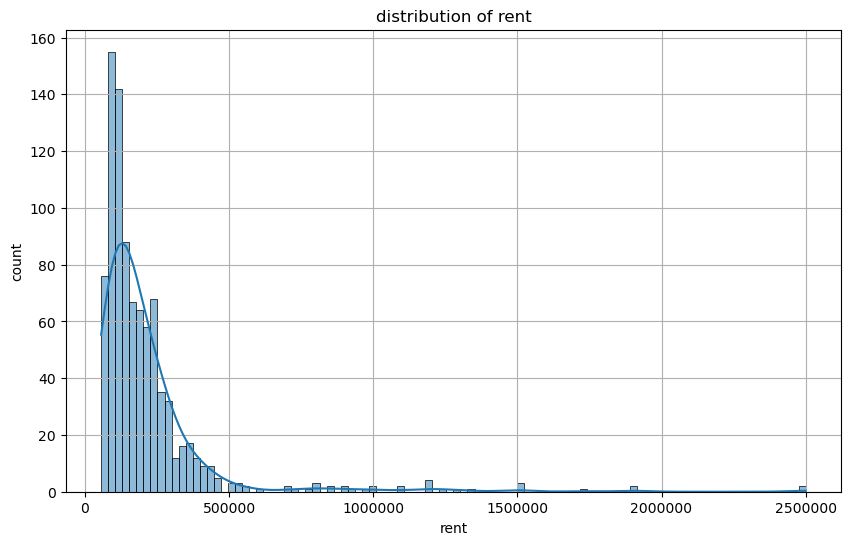

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 必要項目取得
cur.execute('SELECT id,title, address, access, age, floor, fee, management_fee, deposit, gratuity, madori, menseki  FROM houses;')
data2 = cur.fetchall()

# "fee"と"management_fee"を併せた値でソートして"data2"に入れる

# ソートのための関数を定義
def sum_or_none(row):
    value1 = row["fee"]*10000 if row["fee"] is not None else 0
    value2 = row["management_fee"] if row["management_fee"] is not None else 0
    return value1 + value2

# 昇順にソート
sorted_data = sorted(data2, key=sum_or_none)

#3σ法考慮してない　後で使う
df = pd.DataFrame(sorted_data)
df['total_fee'] = df['fee'] * 10000 + df['management_fee'].fillna(0)

Y = df['total_fee']
X = df[['access', 'age', 'floor', 'menseki']]

# "fee"と"management_fee"だけを取り出して併せた値を"rent_list"に入れる
rent_list = []
for house in sorted_data:
    if house["management_fee"] is None:
        rent_list.append(int(house["fee"]*10000))
    else:
        rent_list.append(int(int(house["fee"]*10000))+int(house["management_fee"]))


# Seabornを使って家賃分布のヒストグラムをプロット
print("データの個数：",len(rent_list))
data = {'rent': rent_list}
dataf = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.histplot(dataf['rent'],kde=True ,bins = 100)
plt.title('distribution of rent')
plt.xlabel('rent')
plt.ylabel('count')
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.show()

データの個数： 883


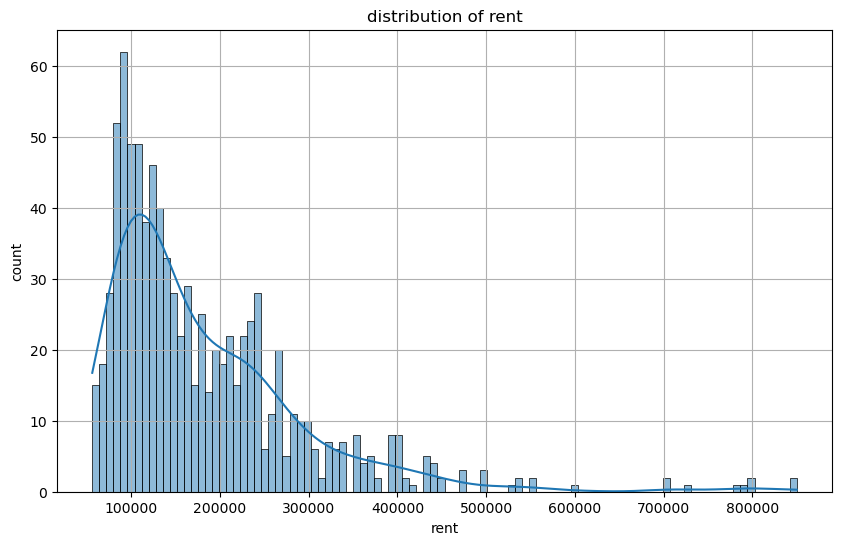

In [45]:
# 平均値
mu = df['fee'].mean()
# 標準偏差
sigma = df['fee'].std()
# 3σ法の中身を取得
df2 = df[(mu - 3 * sigma <= df['fee']) & (df['fee'] <= mu + 3 * sigma)]
print("データの個数：",len(df2))

# "fee"と"management_fee"だけを取り出して併せた値を"rent_list2"に入れる
df2.loc[:, 'total_fee'] = df2['fee'] * 10000 + df2['management_fee'].fillna(0)

# 結果を表示
Y2 = df2['total_fee']
X2 = df2[['access', 'age', 'floor', 'menseki']]


plt.figure(figsize=(10, 6))
# bins50に
sns.histplot(df2['total_fee'],kde=True ,bins = 100)
plt.title('distribution of rent')
plt.xlabel('rent')
plt.ylabel('count')
plt.grid(True)
plt.show()

In [47]:
#3σ法なしで
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.impute import SimpleImputer


# 欠損値を平均値で補完
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

x_train, x_test, t_train, t_test = train_test_split(
   X_imputed, Y, test_size=0.3, random_state=0)

# 学習モデルを作成（毎回値が変わらないようにrandom_stateは０）
model =RF(random_state=0)

# 学習モデルにテストデータを与えて学習させる
model.fit(x_train, t_train)


score = model.score(x_test, t_test)

print(f"正解率：{score * 100}%")

正解率：68.05145940068154%


In [49]:
#3σ法あり
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.impute import SimpleImputer

# 欠損値を平均値で補完
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X2)

x_train, x_test, t_train, t_test = train_test_split(
   X_imputed, Y2, test_size=0.3, random_state=0)

# 学習モデルを作成（毎回値が変わらないようにrandom_stateは０）
model =RF(random_state=0)

# 学習モデルにテストデータを与えて学習させる
model.fit(x_train, t_train)


score = model.score(x_test, t_test)

print(f"正解率：{score * 100}%")

正解率：80.47780846561993%


In [51]:
# 家賃を予測する
new_data = pd.DataFrame({
    'access': [15], 
    'age': [8],
    'floor': [1.0],
    'menseki': [20]
})
new_data_values = new_data.values


# 予測
predicted_price = model.predict(new_data_values)

# 予測された価格を表示
print(f"予測された家の価格: {predicted_price[0]} 円")

予測された家の価格: 110545.0 円


In [53]:
# いろいろな方法で予測してみる
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# 線形回帰で予測する
def Linear_Regression(x_train, t_train, x_test,t_test):  

    lr = LinearRegression()
    lr.fit(x_train, t_train)

    score = lr.score(x_test, t_test)
    return f"線形回帰:正解率：{score * 100}%"

# リッジ回帰で予測する
def Ridge_Regression(x_train, t_train, x_test,t_test, ALPHA=10.0):  

    ridge = Ridge(alpha=ALPHA)
    ridge.fit(x_train, t_train)

    score = ridge.score(x_test, t_test)
    return f"リッジ回帰:正解率：{score * 100}%"    

# Lasso回帰で予測する
def Lasso_Regression(xx_train, t_train, x_test,t_test, ALPHA=0.05):  
    
    lasso = Lasso(alpha=ALPHA)
    lasso.fit(x_train, t_train)

    score = lasso.score(x_test, t_test)
    return f"Lasso回帰:正解率：{score * 100}%"  

# ElasticNet回帰で予測する
def ElasticNet_Regression(x_train, t_train, x_test,t_test, ALPHA=0.05):  
   
    elasticnet = ElasticNet(alpha=ALPHA)
    elasticnet.fit(x_train, t_train)

    score = elasticnet.score(x_test, t_test)
    return f"ElasticNet回帰:正解率：{score * 100}%"  

# GBDTで予測する
def GradientBoosting_Regressor(x_train, t_train, x_test,t_test):  

    GBDT = GradientBoostingRegressor()
    GBDT.fit(x_train, t_train)

    score = GBDT.score(x_test, t_test)
    return f"GBDT:正解率：{score * 100}%"  

# SVRで予測する
def SVR_Regression(x_train, t_train, x_test,t_test):  
    
    svr = SVR()
    svr.fit(x_train, t_train)

    score = svr.score(x_test, t_test)
    return f"SVR:正解率：{score * 100}%"
    
def main():
    
 # 関数をリストに格納
 functions = [Linear_Regression,Ridge_Regression, Lasso_Regression,ElasticNet_Regression,GradientBoosting_Regressor,SVR_Regression]


 # すべての関数を実行し、結果をリストに格納
 results = [func(x_train, t_train, x_test,t_test) for func in functions]

 return results

     
# 一件ずつ出力
if __name__ == "__main__":
    pred_all = main()
    for result in pred_all:
        print(result)




線形回帰:正解率：19.750267916413044%
リッジ回帰:正解率：19.750029440495275%
Lasso回帰:正解率：19.750269000173446%
ElasticNet回帰:正解率：19.74987767284826%
GBDT:正解率：84.03963796924828%
SVR:正解率：-10.178427614265416%
